In [156]:
import numpy as np
import scipy
from scipy.sparse import sparray
import matplotlib.pyplot as plt
import math

# Parameters

In [184]:
# max integer
N = 10000

# weight parameters
alpha = 1.
beta = 2.

# curvature parameters
gamma = 0.5

# num of eigenfunctions
num_func = 12

In [185]:
xs = np.arange(N)
cs = (1 + xs[:-1]) ** gamma
ws = (1 + xs) ** (-beta)

cs /= np.sum(cs)
ws /= np.sum(ws)

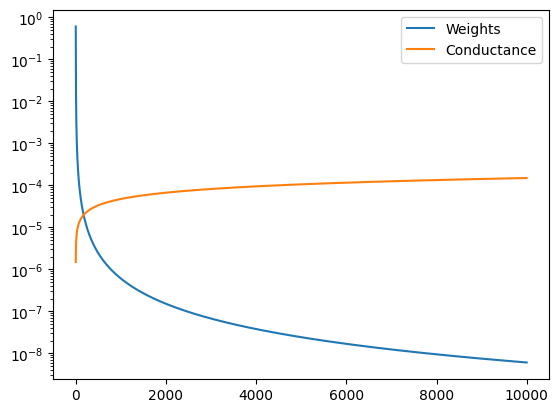

In [186]:
plt.plot(xs, ws, label='Weights')
plt.plot(xs[:-1], cs, label='Conductance')
plt.yscale('log')
plt.legend()
plt.show()

# Compute eigenfunctions

In [187]:
def build_cs_matrix(cs):
    head = cs[:-1]
    tail = cs[1:]
    main_diagonal = np.r_[head[0], head + tail, tail[-1]]
    off_diagonal = -cs
    return scipy.sparse.diags_array(
        (off_diagonal, main_diagonal, off_diagonal),
        offsets=[-1, 0, 1],
    )

def compute_eigenfunctions(cs, ws, k):
    cs_mat = build_cs_matrix(cs)
    ds_mat = scipy.sparse.diags_array((1 / np.sqrt(ws)))
    eig_mat = ds_mat @ cs_mat @ ds_mat

    main_diag = eig_mat.diagonal(0)
    off_diag = eig_mat.diagonal(-1)
    vals, vecs = scipy.linalg.eigh_tridiagonal(main_diag, off_diag, select='i', select_range=(0, k - 1))
    ortho_vecs = (vecs.T / np.sqrt(ws)).T
    return vals, ortho_vecs

In [188]:
vals, vecs = compute_eigenfunctions(cs, ws, num_func)

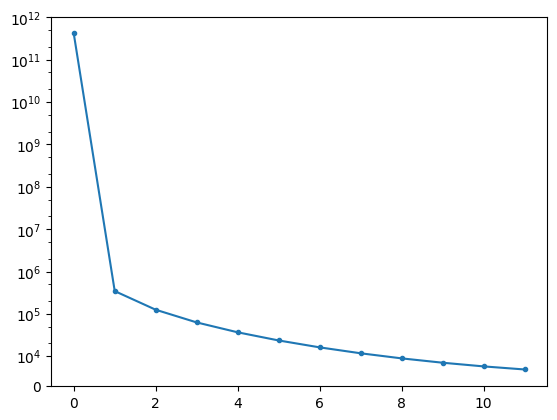

In [189]:
plt.plot(np.reciprocal(vals), marker='o', markersize=3)
plt.yscale('asinh', linear_width=np.min(np.reciprocal(vals)))
plt.show()

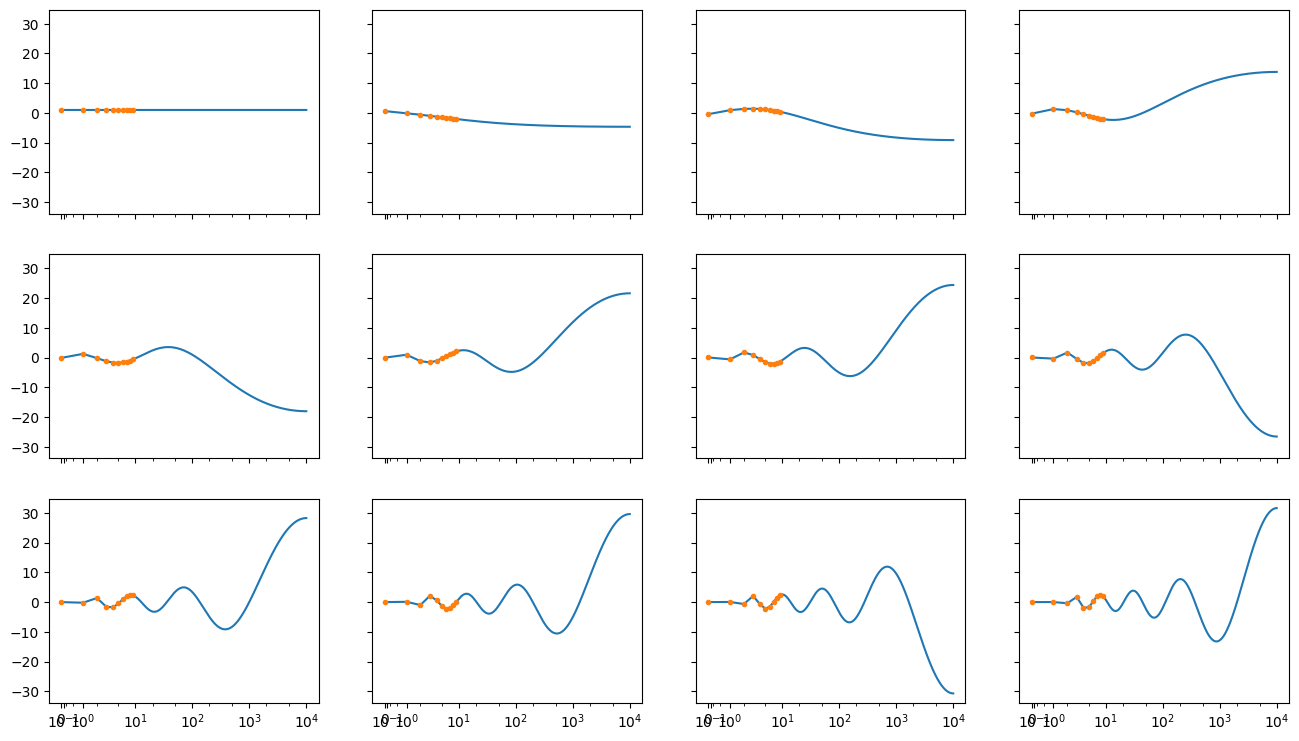

In [190]:
rows = math.floor(math.sqrt(num_func))
cols = math.ceil(num_func / rows)
fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows), sharex=True, sharey=True)
for i in range(num_func):
    ax = axs[i // cols, i % cols]
    ax.plot(xs, vecs[:, i])
    ax.plot(xs[:10], vecs[:10, i], marker='o', markersize=3, linestyle='None')
    ax.set_xscale('asinh')
plt.show()

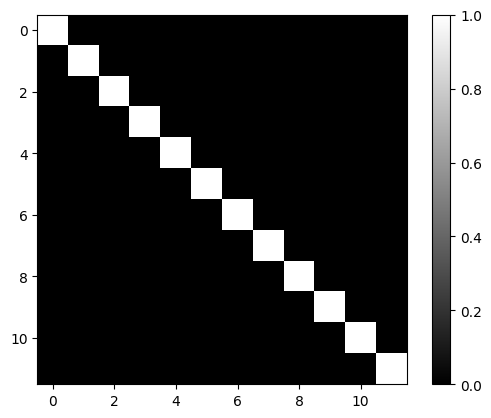

In [166]:
plt.imshow(vecs.T * ws @ vecs, cmap='gray')
plt.colorbar()
plt.show()